## 基于回火转移和并行回火的马尔可夫链在能量模型上的采样实现

### 背景介绍

在马尔可夫链蒙特卡罗方法（MCMC）中，当目标分布具有多个尖锐的高概率峰值（模式），并被低概率区域  
分隔时，马尔可夫链在这些模式之间的混合变得非常困难。为解决问题，引入了  **回火（Tempering）**  
的方法，通过调节温度参数来平滑分布的峰值，使马尔可夫链更容易在不同模式之间转换。


### 能量模型与温度参数

能量模型定义的概率分布为：

$$
p(x) \propto \exp(-E(x))
$$

通过引入温度参数 $\beta$，可以控制分布的尖锐程度：

$$
p_{\beta}(x) \propto \exp(-\beta E(x))
$$

- 当温度较高（$\beta < 1$）时，分布更平滑，峰值较低，谷值较高。
- 当温度降低到零（$\beta \to \infty$）时，分布变得非常尖锐。


### 实现步骤

1. **定义能量函数 $E(x)$**：  
   选择一个适合演示的能量函数。
   
2. **基于回火转移的采样**：  
   实现基于回火转移的马尔可夫链采样。

3. **利用并行回火的采样**：  
   实现并行回火的马尔可夫链采样。

4. **结果可视化**：  
   展示采样得到的结果，比较两种方法的效果。

### 1. 定义能量函数 $E(x)$

我们选择一个二维的能量函数，使目标分布具有多个模式，便于观察采样效果。

#### 能量函数示例

考虑以下能量函数：

$$
E(x) = - \log \left( \exp \left( -\frac{(x_1 - 2)^2 + (x_2 - 2)^2}{2} \right) + \exp \left( -\frac{(x_1 + 2)^2 + (x_2 + 2)^2}{2} \right) \right)
$$

该能量函数对应于两个高斯分布的混合，中心分别位于 $(2, 2)$ 和 $(-2, -2)$，具有相同的方差。

In [2]:
import torch

# 定义能量函数 E(x)
def energy(x):
    # x: Tensor of shape (batch_size, 2)
    x1 = x[:, 0]
    x2 = x[:, 1]
    term1 = torch.exp(-0.5 * ((x1 - 2)**2 + (x2 - 2)**2))
    term2 = torch.exp(-0.5 * ((x1 + 2)**2 + (x2 + 2)**2))
    E = -torch.log(term1 + term2 + 1e-10)  # 防止取log(0)
    return E


## 2. 基于回火转移的马尔可夫链采样

**回火转移（Tempered Transitions）**方法通过在高温度（低 $\beta$）下进行采样，使马尔可夫链能够越过能量障碍，然后回到原始温度，从而在模式之间混合。

### 实现步骤

1. **设定温度序列**：  
   从 $\beta=1$ 开始，逐步降低到较低的温度，然后再升回 $\beta=1$。

2. **向前过程**：  
   根据温度序列，从当前状态开始，依次在每个温度下进行采样，直到最低温度。

3. **向后过程**：  
   在返回的过程中，依次在每个温度下进行采样，直到回到原始温度。

4. **接受概率**：  
   计算整个路径的接受概率，决定是否接受新的状态。


In [21]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

# 定义能量函数
def energy(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    term1 = torch.exp(-0.5 * ((x1 - 2)**2 + (x2 - 2)**2))
    term2 = torch.exp(-0.5 * ((x1 + 2)**2 + (x2 + 2)**2))
    energy_value = -torch.log(term1 + term2 + 1e-10)
    return energy_value.squeeze()

def tempered_transition_sampling(E, x_current, num_steps, beta_schedule, proposal_std):
    x = x_current.clone()
    x_forward = [x.clone()]

    # 向前过程
    for idx, beta in enumerate(beta_schedule):
        # 提议新状态
        x_proposed = x + torch.randn_like(x) * proposal_std
        # 计算能量差
        delta_E = E(x_proposed.unsqueeze(0)) - E(x.unsqueeze(0))
        delta_E = delta_E.item()
        # 限制 delta_E 的范围
        delta_E = max(min(delta_E, 100), -100)
        # 计算接受概率
        acceptance_prob = min(1.0, math.exp(-beta * delta_E))

        # 接受或拒绝
        if torch.rand(1).item() < acceptance_prob:
            x = x_proposed.clone()
        x_forward.append(x.clone())

    # 向后过程
    x_backward = x_forward[::-1]
    x_new = x_backward[-1].clone()

    # 计算整个路径的接受概率
    log_acceptance_ratio = 0.0
    for i in range(len(beta_schedule) - 1):
        beta_forward = beta_schedule[i]
        beta_backward = beta_schedule[-(i+1)]
        x_i = x_forward[i]
        x_ip1 = x_forward[i+1]

        delta_E_forward = E(x_ip1.unsqueeze(0)) - E(x_i.unsqueeze(0))
        delta_E_backward = E(x_i.unsqueeze(0)) - E(x_ip1.unsqueeze(0))

        delta_E_forward = delta_E_forward.item()
        delta_E_backward = delta_E_backward.item()

        delta_E_forward = max(min(delta_E_forward, 100), -100)
        delta_E_backward = max(min(delta_E_backward, 100), -100)

        log_acceptance_ratio += - (beta_forward * delta_E_forward - beta_backward * delta_E_backward)

    log_acceptance_ratio = max(min(log_acceptance_ratio, 100), -100)
    acceptance_ratio = min(1.0, math.exp(log_acceptance_ratio))

    # 最终决定是否接受新状态
    if torch.rand(1).item() < acceptance_ratio:
        return x_new.clone()
    else:
        return x_current.clone()


### 采样过程

In [23]:
# 参数设置
num_samples = 5000
proposal_std = 1.0  # 可以根据需要调整
x_current = torch.tensor([0.0, 0.0])

# 定义温度序列
beta_forward = np.linspace(1.0, 0.1, 10)
beta_backward = beta_forward[::-1][1:]
beta_schedule = np.concatenate([beta_forward, beta_backward])
beta_schedule = torch.tensor(beta_schedule, dtype=torch.float32)

# 运行采样
samples_tempered = []
for sample_idx in range(num_samples):
    x_current = tempered_transition_sampling(energy, x_current, num_steps=1, beta_schedule=beta_schedule, proposal_std=proposal_std)
    samples_tempered.append(x_current.numpy())

samples_tempered = np.array(samples_tempered)

## 3. 利用并行回火的马尔可夫链采样

**并行回火（Parallel Tempering）**：  
   方法同时运行多条马尔可夫链，每条链对应不同的温度。通过在不同温度的链之间交换状态，  
   高温链可以帮助低温链跳出局部极小值，实现更好的混合。

### 实现步骤

1. **初始化多条链**：  
   每条链对应一个温度 $\beta$，温度从低到高排列。温度较低的链更加尖锐，温度较高的链较为平滑。

2. **在每条链上进行 MCMC 采样**：  
   在对应温度下，每条链独立地进行 Metropolis-Hastings 更新，生成样本。

3. **交换步骤**：  
   定期尝试在相邻温度的链之间交换状态，按照一定的接受概率计算：
   
   $$
   \alpha = \min\left(1, \frac{p_{\beta_i}(x_j) \cdot p_{\beta_j}(x_i)}{p_{\beta_i}(x_i) \cdot p_{\beta_j}(x_j)}\right)
   $$
   
   其中 $x_i$ 和 $x_j$ 分别是第 $i$ 和第 $j$ 条链的当前状态，$\beta_i$ 和 $\beta_j$ 分别是对应的温度。


In [5]:
def parallel_tempering_sampling(E, num_chains, num_samples, proposal_std, swap_interval):
    """
    实现并行回火的马尔可夫链采样。

    参数：
    - E: 能量函数
    - num_chains: 链的数量
    - num_samples: 每条链的采样数
    - proposal_std: 提议分布的标准差
    - swap_interval: 交换间隔

    返回：
    - samples: 采样结果，形状为 (num_samples, num_chains, 2)
    """
    # 定义温度序列
    betas = torch.linspace(0.1, 1.0, num_chains)
    # 初始化每条链的状态
    x = torch.randn(num_chains, 2) * 2.0  # 随机初始化

    samples = []
    for i in range(num_samples):
        # 在每条链上进行MCMC更新
        for j in range(num_chains):
            x_current = x[j].unsqueeze(0)
            beta = betas[j]
            # 提议新状态
            x_proposed = x_current + torch.randn_like(x_current) * proposal_std
            # 计算能量差
            delta_E = E(x_proposed) - E(x_current)
            # 计算接受概率
            acceptance_prob = torch.exp(-beta * delta_E).clamp(max=1.0)
            # 接受或拒绝
            if torch.rand(1) < acceptance_prob:
                x[j] = x_proposed.squeeze()

        # 定期进行交换
        if i % swap_interval == 0:
            for k in range(num_chains - 1):
                # 尝试交换链 k 和链 k+1 的状态
                beta_k = betas[k]
                beta_k1 = betas[k+1]
                xk = x[k].unsqueeze(0)
                xk1 = x[k+1].unsqueeze(0)

                delta = (beta_k - beta_k1) * (E(xk1) - E(xk))
                acceptance_prob = torch.exp(delta).clamp(max=1.0)

                if torch.rand(1) < acceptance_prob:
                    # 交换状态
                    x[k], x[k+1] = x[k+1], x[k]

        samples.append(x.clone().detach().numpy())

    samples = np.array(samples)
    return samples


### 采样过程

In [6]:
# 参数设置
num_chains = 10
num_samples = 5000
proposal_std = 0.5
swap_interval = 10

# 运行并行回火采样
samples_parallel = parallel_tempering_sampling(energy, num_chains, num_samples, proposal_std, swap_interval)

# 提取温度为1的链的采样结果
samples_parallel_T1 = samples_parallel[:, -1, :]  # 温度最高的链


### 4. 结果可视化
绘制基于回火转移的采样结果

In [ ]:
import matplotlib.pyplot as plt

# 绘制采样结果的散点图
plt.figure(figsize=(6, 3))
plt.scatter(samples_tempered[:, 0], samples_tempered[:, 1], alpha=0.5, s=10)
plt.title('Samples from Tempered Transitions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


绘制并行回火的采样结果

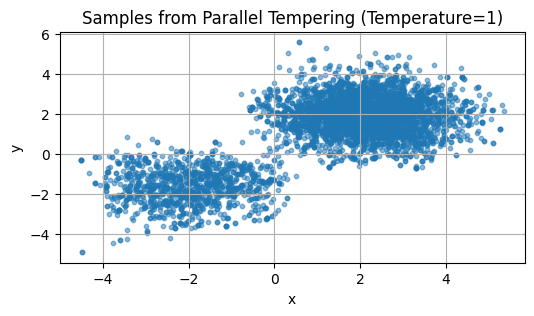

In [10]:
# 绘制采样结果的散点图
plt.figure(figsize=(6, 3))
plt.scatter(samples_parallel_T1[:, 0], samples_parallel_T1[:, 1], alpha=0.5, s=10)
plt.title('Samples from Parallel Tempering (Temperature=1)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


绘制能量函数的等高线图

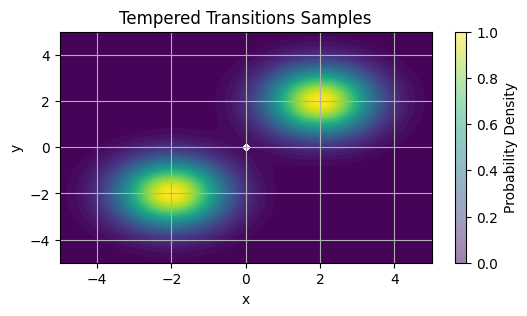

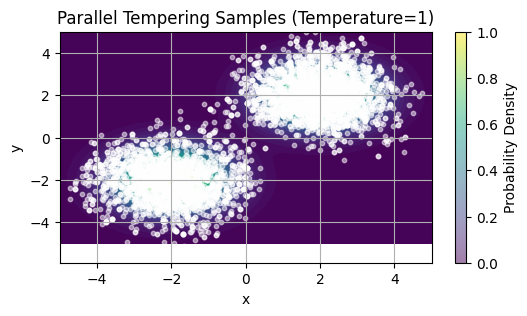

In [13]:
# 创建网格用于绘制等高线
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.ravel(), Y.ravel()], axis=1)
XY_torch = torch.tensor(XY, dtype=torch.float32)

# 计算能量值
with torch.no_grad():
    E_values = energy(XY_torch).numpy()

E_values = E_values.reshape(X.shape)

# 绘制等高线图和采样点（基于回火转移）
plt.figure(figsize=(6, 3))
plt.contourf(X, Y, np.exp(-E_values), levels=50, cmap='viridis')
plt.scatter(samples_tempered[:, 0], samples_tempered[:, 1], alpha=0.5, s=10, color='white')
plt.title('Tempered Transitions Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Probability Density')
plt.grid(True)
plt.show()

# 绘制等高线图和采样点（并行回火）
plt.figure(figsize=(6, 3))
plt.contourf(X, Y, np.exp(-E_values), levels=50, cmap='viridis')
plt.scatter(samples_parallel_T1[:, 0], samples_parallel_T1[:, 1], alpha=0.5, s=10, color='white')
plt.title('Parallel Tempering Samples (Temperature=1)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Probability Density')
plt.grid(True)
plt.show()


### 5. 结果分析

- 基于回火转移的采样：可以看到，采样点较好地覆盖了目标分布的两个模式，能够在模式之间进行转换。

- 并行回火的采样：温度为1的链（最低温度）的采样结果也较好地覆盖了目标分布的模式。通过高温链  
的帮助，低温链能够更容易地跳出局部极小值，实现更好的混合。

### 参考文献：

Neal, R. M. (1994). An improved acceptance procedure for the hybrid Monte Carlo algorithm.  
*Journal of Computational Physics*, 111(1), 194-203.  
Iba, Y. (2001). Extended ensemble Monte Carlo. *International Journal of Modern Physics C*, 12(05), 623-656.